In [1]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 81.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install --upgrade Pillow
import os
import cv2

import torch
import torch.nn as nn
import numpy as np
import albumentations as A
from facenet_pytorch import MTCNN
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 40.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.3 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
ydata-profiling 4.12.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def process_image(image_path):
    """
    Обрабатывает изображение: выделяет лицо, создает маску и возвращает обрезанное изображение, маску (0, 1) и исходное изображение.

    Args:
        image_path (str): Путь к изображению.

    Returns:
        tuple: (исходное изображение, обрезанное изображение с черным фоном, маска 0/1)
    """
    image = Image.open(image_path).convert("RGB")
    img = cv2.imread(image_path)

    mtcnn = MTCNN(keep_all=True)
    boxes, _ = mtcnn.detect(image)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            mask[y1:y2, x1:x2] = 255 

    black_background = img.copy()
    black_background[mask == 0] = [0, 0, 0]

    model = deeplabv3_resnet101(pretrained=True)
    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = torch.argmax(output, dim=0).byte().cpu().numpy()

    face_mask = (output_predictions == 15).astype(np.uint8)  # Класс "person" в DeepLabv3

    if face_mask.shape != img.shape[:2]:
        face_mask = cv2.resize(face_mask, (img.shape[1], img.shape[0]))  # Приводим маску к размеру изображения

    face_mask_binary = (face_mask > 0).astype(np.uint8)
    result_refined = cv2.bitwise_and(img, img, mask=face_mask_binary)
    return img, result_refined, face_mask_binary

def display_results(original, refined, mask):
    """
    Показывает три изображения в строке: исходное, обрезанное и маску.

    Args:
        original (ndarray): Исходное изображение.
        refined (ndarray): Обрезанное изображение с черным фоном.
        mask (ndarray): Маска (0, 1).
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(refined, cv2.COLOR_BGR2RGB))
    plt.title("Refined Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [5]:
img, result_refined, face_mask_binary = process_image('/kaggle/input/imdb-clean/imdb-clean-1024/imdb-clean-1024/00/nm0000100_rm1002674432_1955-1-6_2003.jpg')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 163MB/s]  


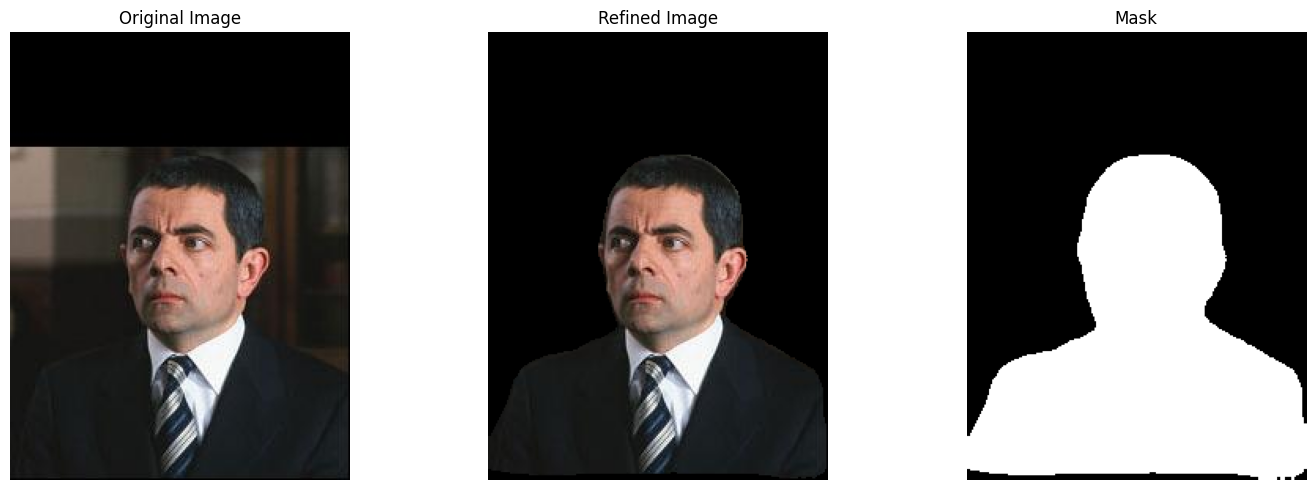

In [6]:
display_results(img, result_refined, face_mask_binary)

## Обучение

In [7]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.20
    Uninstalling albucore-0.0.20:
      Successfully uninstalled albucore-0.0.20
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.21
    Uninstalling albumentations-1.4.21:
      Successfully uninstalled albumentations-1.4.21


In [16]:
def get_paths(root_path):
    """
    Обходит все директории внутри заданного пути и возвращает список путей ко всем изображениям.

    Args:
        root_path (str): Корневая директория.

    Returns:
        np.ndarray: Массив путей ко всем изображениям.
    """
    images_paths = []

    for dirpath, _, filenames in os.walk(root_path):
        for filename in sorted(filenames):
            if filename.lower().endswith(('.jpg', '.jpeg')):
                images_paths.append(os.path.join(dirpath, filename))

    return np.stack(images_paths)

class FaceDataset(Dataset):
    def __init__(self, images, transform, aug=None, padded=False, normalize=False):
        self.images, self.masks = [], []
        self.transform = transform
        self.aug = aug
        self.padded = padded
        if normalize:
            self.normalize = transforms.Normalize((0.485, 0.456, 0.406),
                                                  (0.229, 0.224, 0.225))
        
        for im_path in sorted(images):
            augmentations = [None] + self.aug if self.aug else [None]
            image, _, mask = process_image(im_path)
            image = image / 255.0 
            mask = (mask > 0).astype(np.float32)
            for aug in augmentations:
                self.load_aug_data(image, mask, aug)
    
    def __len__(self):
        return len(self.images)
    
    def load_aug_data(self, image, mask, aug):
        if aug is None:
            self.images.append(image)
            self.masks.append(mask)
        else:
            augmented = aug(image=image, mask=mask)
            self.images.append(augmented['image'])
            self.masks.append(augmented['mask'])
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.padded:
            padded = A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0)
            augmented = padded(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        image = self.transform(image).float()
        mask = self.transform(mask).float()
        if self.normalize:
             image = self.normalize(image)
        return {'image': image,
                'mask' : mask}

In [9]:
image_paths = get_paths("/kaggle/input/imdb-clean/imdb-clean-1024/imdb-clean-1024")                  

In [10]:
len(image_paths)

285946

In [12]:
image_paths = np.random.choice(image_paths, 50000)

In [13]:
def split_train_test(data, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    # Перемешиваем данные
    indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return data[train_indices], data[test_indices]


X_train, X_test = split_train_test(image_paths, test_size=0.2)

In [14]:
transform = transforms.Compose([
    transforms.ToTensor()])

augmentation_pipeline = [
            A.HorizontalFlip(p=1),        
            A.Rotate(limit=35, p=1),                                        
            A.VerticalFlip(p=1),                        
            A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0)]  

In [ ]:
dataset = FaceDataset(
    images=X_train,
    transform=transform, 
    aug=augmentation_pipeline, 
    padded=True, normalize=True
)

In [ ]:
def show_example(dataset, idx):
    sample = dataset[idx]
    image = sample['image']
    mask = sample['mask']

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.axis('off') 
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0))
    plt.axis('off') 
    
    plt.show()

In [ ]:
show_example(dataset, 440)

In [ ]:
print(f"Dataset length {len(dataset)}")

In [ ]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

def dice_loss(target, prediction, eps=1e-8):
    prediction = torch.sigmoid(prediction)
    intersection = torch.sum(target * prediction)
    total = torch.sum(target) + torch.sum(prediction)
    
    loss = 1 - (2 * intersection + eps) / (total + eps)
    return loss.mean()

In [ ]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    return images

### LinkNet architecture:
In LinkNet, the input of each encoder layer is also passed to the output of its corresponding decoder. See [paper](https://www.theobjects.com/dragonfly/dfhelp/Content/Resources/PDFs/linknet.pdf).

<img src="https://wiki.cloudfactory.com/media/pages/docs/mp-wiki/model-architectures/linknet/b19f6073bd-1684131960/linknet.webp">

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if stride > 1 else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv2(self.conv1(x))
        return nn.ReLU(inplace=True)(out + residual)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super().__init__()
        self.blocks = nn.Sequential(
            EncoderBlock(in_channels, out_channels, kernel_size, stride, padding, groups, bias),
            EncoderBlock(out_channels, out_channels, kernel_size, 1, padding, groups, bias)
        )

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        super().__init__()
        mid_channels = in_channels // 4
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(mid_channels, mid_channels, kernel_size, stride, padding, output_padding, bias=bias),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)
    
    
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.tp_conv1 = self._conv_transpose_block(64, 32)
        self.conv2 = self._conv_block(32)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, kernel_size=2, stride=2)

    def _conv_block(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
    
    def _conv_transpose_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.tp_conv2(self.conv2(self.tp_conv1(x)))
    
class LinkNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=False):
        super().__init__()
        if pretrained:
            base = resnet.resnet18(pretrained=True)

            self.in_block = nn.Sequential(
                base.conv1,
                base.bn1,
                base.relu,
                base.maxpool
            )

            self.encoders = nn.ModuleList([base.layer1,
                                           base.layer2,
                                           base.layer3,
                                           base.layer4])
        else:
            self.in_block = nn.Sequential(
                nn.Conv2d(3, 64, 7, 2, 3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, 2, 1)
            )
            
            encoder_params = [
                (64, 64, 3, 1, 1),
                (64, 128, 3, 2, 1),
                (128, 256, 3, 2, 1),
                (256, 512, 3, 2, 1)
            ]

            self.encoders = nn.ModuleList([Encoder(*params) for params in encoder_params])
        
        decoder_params = [
            (64, 64, 3, 1, 1, 0),
            (128, 64, 3, 2, 1, 1),
            (256, 128, 3, 2, 1, 1),
            (512, 256, 3, 2, 1, 1)
        ]
        
        self.decoders = nn.ModuleList([Decoder(*params) for params in decoder_params])


        # Classifier
        self.final = Classifier(n_classes)


    def forward(self, x):
        # Initial block
        x = self.in_block(x)

        # Encoder blocks
        e1 = self.encoders[0](x)
        e2 = self.encoders[1](e1)
        e3 = self.encoders[2](e2)
        e4 = self.encoders[3](e3)

        # Decoder blocks
        d4 = e3 + self.decoders[3](e4)
        d3 = e2 + self.decoders[2](d4)
        d2 = e1 + self.decoders[1](d3)
        d1 = x + self.decoders[0](d2)

        return self.final(d1)

In [ ]:
X_test = get_paths("/kaggle/input/hw2-segmentation/data/test/images")
y_test = get_paths("/kaggle/input/hw2-segmentation/data/test/gt")


test_dataset = FaceDataset(
    images=X_test, 
    masks=y_test, 
    transform=transform, 
    aug=None, 
    padded=True, normalize=True
)

In [ ]:
from tqdm import tqdm

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    ious = []
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = central_crop(batch["mask"].to(device), 370)
            
            outputs = central_crop(model(images), 370)
            loss = dice_loss(masks, outputs)
            val_loss += loss.item()
            
            iou = calc_iou(outputs.to('cpu').detach().numpy(), masks.to('cpu').numpy())
            ious.append(iou)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = sum(ious) / len(ious)
    
    return {
            "val_loss": avg_val_loss,
            "val_iou": avg_iou
            }



def train_model(model, train_loader, val_loader, optimizer, sheduler, n_epochs):
    model.to(device)
    
    metrics = {
        "train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []
    }
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        ious = []
        for batch in train_loader:
            optimizer.zero_grad()
            images = batch["image"].to(device)
            masks = central_crop(batch["mask"].to(device), 370)
            
            outputs = central_crop(model(images), 370)
            loss = dice_loss(masks, outputs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            iou = calc_iou(outputs.to('cpu').detach().numpy(), masks.to('cpu').numpy())
            ious.append(iou)
        scheduler.step()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = sum(ious) / len(ious)
        
        val_metrics = validate_model(model, val_loader)
        
        metrics["train_loss"].append(avg_train_loss)
        metrics["train_iou"].append(avg_train_iou)
        metrics["val_loss"].append(val_metrics["val_loss"])
        metrics["val_iou"].append(val_metrics["val_iou"])
        

        print(f'Epoch [{epoch+1}/{n_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train IoU: {avg_train_iou:.4f}, '
              f'Val Loss: {val_metrics["val_loss"]:.4f}, '
              f'Val IoU: {val_metrics["val_iou"]:.4f}')
    
    return model, metrics


In [ ]:
val_loader = DataLoader(
    test_dataset,           
    batch_size=8,
    shuffle=False,
    num_workers=2
)
train_loader = DataLoader(
    dataset,           
    batch_size=8,
    shuffle=True,
    num_workers=2
)

In [ ]:
model = LinkNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
trained_model, metrics = train_model(model, train_loader, val_loader, optimizer, scheduler, n_epochs=50)

In [ ]:
def plot_metrics(metrics, baseline=0.75):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics["train_loss"], label='Train Loss')
    plt.plot(metrics["val_loss"], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Dice Loss for scratch LinkNet')
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(metrics["val_iou"], label='Validation IoU', color='blue')
    plt.plot(metrics["train_iou"], label='Train IoU', color='orange')

    max_iou_idx = np.argmax(metrics["val_iou"])
    max_iou_value = metrics["val_iou"][max_iou_idx]
    plt.scatter(max_iou_idx, max_iou_value, color='green', zorder=5) 
    plt.text(max_iou_idx, max_iou_value, f'Max IoU: {max_iou_value:.2f}', 
             verticalalignment='bottom', horizontalalignment='right')

    plt.axhline(y=baseline, color='red', linestyle='--', label='Baseline IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('IoU for scratch LinkNet')
    plt.grid()
    plt.show()


In [ ]:
plot_metrics(metrics)

In [ ]:
model = LinkNet(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
trained_model, metrics = train_model(model, train_loader, val_loader, optimizer, scheduler, n_epochs=50)

In [ ]:
plot_metrics(metrics)